# **Atelier 2: Apprentissage supervisé avec Python** 

<strong style='color:red'>  DODO MAMANE Abari p2214579 </strong>



*   Data preprocessing (donné hétérogènes, données manquantes, etc.)
*   Feature engineering
*   Feature selection
*   Classification
*   Evaluation de la qualité d'un classifieur



# **I- Apprentissage supervisé: Feature engineering et classification**
> **Apprentissage supervisé** : L'apprentissage supervisé est une technique d'apprentissage automatique dans laquelle un modèle de machine learning est entraîné à prédire une sortie en utilisant des exemples d'entrée et de sortie précédemment connus. Le modèle est "supervisé" parce qu'il est guidé par des exemples de données d'entraînement qui comprennent des entrées et les sorties correctes associées, de sorte qu'il peut apprendre à faire des prédictions correctes pour de nouvelles entrées.

> **Feature engineering**: Le feature engineering est le processus de création et de sélection des caractéristiques (ou "features") utilisées comme entrées pour un modèle de machine learning. Les features sont les variables indépendantes qui sont utilisées pour faire des prédictions ou des classifications.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
warnings.filterwarnings("ignore")

### **1- Chargement des données et préparation**
* la base de données credit_scoring.csv : Cette base contient des données de clients d'une banque et leur statut qui est de 1 si un credit leur a été accordé et 0 sinon.      
* Évaluation de la solvabilité d'un client souhaitant souscrire à un credit, à base de cette base de données (credit_scoring.csv). 

In [3]:
# Importation des données
data = pd.read_csv('credit_scoring.csv', sep=';')

In [4]:
# Affichage des 5 premiers lignes
data.head() 

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0
3,0.0,1.0,60.0,24.0,1.0,1.0,0.0,63.0,182.0,2500.0,0.0,900.0,1325.0,1
4,0.0,1.0,36.0,26.0,1.0,1.0,0.0,46.0,107.0,0.0,0.0,310.0,910.0,1


In [5]:
# les features
data.columns

Index(['Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records', 'Job',
       'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price', 'Status'],
      dtype='object')

In [6]:
# shape de données
data.shape

(4375, 14)

In [7]:
# Transformation en numpy du jeu de données issue de data
# separation des caracteristiques (features) et la variable à prédire (target)

X = data.iloc[:, :].values

features = X[:, :-1]
target = X[:, -1]
target = target.astype(np.int)

In [8]:
# Analyse des propriétés de la dataset
nbr_neg =sum(target >= 1)
nbr_pos = sum(target <= 0 )
print(f'Shape features: {features.shape} \nShape target: {target.shape}')
print(f'nombre des éléments positifs: {nbr_neg}')
print(f'nombre des éléments négatifs: {nbr_pos}') 

Shape features: (4375, 13) 
Shape target: (4375,)
nombre des éléments positifs: 3159
nombre des éléments négatifs: 1216


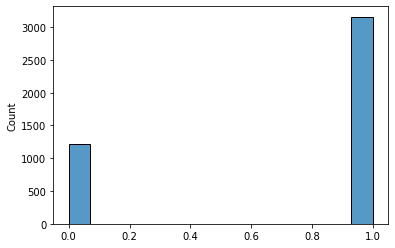

In [9]:
import seaborn as sns
sns.histplot(target)

In [10]:
# Split the data in training and test set
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.5, random_state=1)
print(f"training samples : {y_train.shape[0]}, \n test samples : {y_test.shape[0]}")

training samples : 2187, 
 test samples : 2188


🔑 **Summary**

* Nous avons chargé le fichier __credit_scoring.csv__ contenant les données.
* Il s'agit des caractéristiques telles que (seniority, home, time, age, marital, records, job, expenses, income, assets, debt, amount, price) et status qui est un valeur specifiant si le credit a été accordé à la personne  (status=1) ou pas (status=0).
* Statistiques sur la dataset:
  * Nombre des caractéristiques : 13
  * Nombre d'observations : 4375
  * observation avec status = 1 : 1216
  * Observations avec status = 1 : 3159
* Separation de données en train set et test set:
  * Nombre de training samples : 2187
  * Nombre de test samples : 2188     

## **2- Apprentissage et évaluation de modèles**

> Dans cette partie nous allons utilisées sur notre jeu de données les algorithmes d'apprentissage supervisé suivants : 
> * **Un arbre CART** (random_state=1)
> * **k-plus-proches-voisins** avec k=5
> * **MultilayerPerceptron** à deux couches de tailles respectives 40 et 20 et random_state=1

> * L'objectif est de comparer ces algorithmes en se basant sur l'accuracy et le meilleur critère entre Rappel et la précision.

> ❗ **Choix entre Rappel et Precision** 
>> Le meilleur critère est Précision . En effet la précision est le pourcentage des vraies positifs (True positifs). Dans ce cas s'il s'agit de la portion des personnes ayant réellement un score 1 parmi celles predites avec un score 1. Le meilleur critère est celui qui minimise les faux positifs donc la precision. Rappel(Recall) nous donne le pourcentage de personnes ayant un score de 1 et qui ont été predites comme telles. Le recall ne minimise pas les faux positifs, mais plutot les faux negatifs. Donc avec precision élévée on a plus de chance de ne pas octroyer un credit à celui qui n'est pas solvable.   

In [11]:
# Training models
def train(models, x_train, y_train):
  """
  Cette fonction prend en entrée un dictionnaire des models et les données
  d'entrainement et entraine ces models.

  Parameters:
  models (dict) : dictionnaire des models tel {'model_name': object, ...}
  x_train (ndarray) : données d' entrainement (features)
  y_train (ndarray) : labels   
  """
  for model in models.values():
    model.fit(x_train, y_train)

# Evaluate models
def evaluate(models, x_test, y_test):
  """
  Cette fonction prend en entrée un dictionnaire de models et données de test et
  évalue ces models en utilisant l'accuracy et la precision  
  Parameters:
  models (dict) : dictionnaire des models tel que {'model_name': object, ...}
  x_test (ndarray) : données de test (features)
  y_test (ndarray) : labels   
  """
  results = {'classifier': [], 'precision': [], 'accuracy': []}
  for model_name, model in models.items():
    y_predicted = model.predict(x_test)
    
    results['classifier'].append(model_name)
    results['accuracy'].append(metrics.accuracy_score(y_test, y_predicted))
    results['precision'].append(metrics.precision_score(y_test, y_predicted))
  
  return pd.DataFrame(results)   

def confusion_matrix(models, x_test, y_test):
  """
        Display Confusion Matrix given y_test and y_pred and the model
  """
  nbr = len(models.keys())
  i = 1
  plt.figure(figsize=(20, 15))
  for model_name, model in models.items():
    #plt.subplot(nbr // 2 + 1 , nbr//2 + 1, i) 
    ax = plt.subplot(nbr // 3 + 1, 3, i)
    ax.set_title(model_name)
    y_predicted = model.predict(x_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
    cm_display.plot(ax=ax)
    i+=1 

  plt.show()

In [12]:
# Les modèles
models = {
    'cart' : DecisionTreeClassifier(random_state=1),
    'knn' : KNeighborsClassifier(n_neighbors=5),
    'mlp' : MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
}

In [13]:
# entrainement des modèles
train(models, x_train, y_train)

In [14]:
# Evaluation des modèles
evaluate(models, x_test, y_test).style.hide_index()

classifier,precision,accuracy
cart,0.819417,0.727148
knn,0.770971,0.724863
mlp,0.795644,0.697898


🔑 **Evaluation des modèles sans pretraitement**

* Le classifier cart à la meilleure precision et le meilleur accuracy
* Le classifier mlp a le plus petit accuracy. 
* Sans pretraitement (normalisation et autres) le classifier qui a le plus de precision et d'accuracy est le cart.   

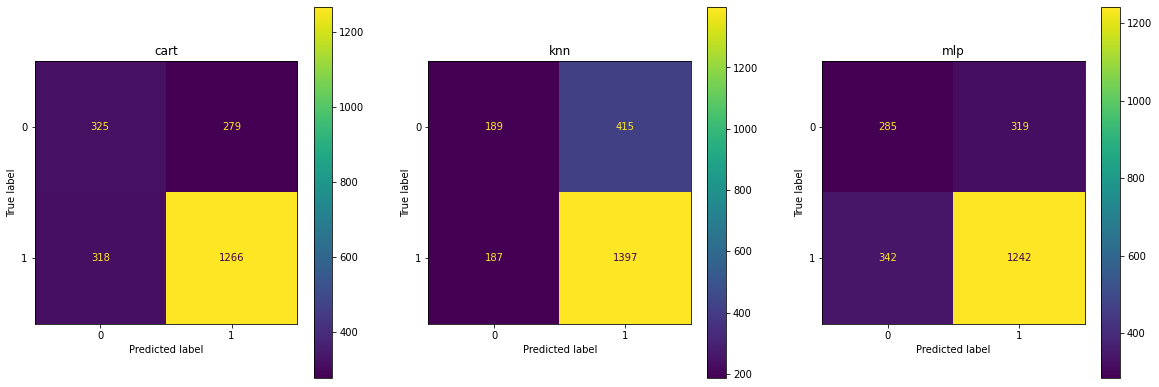

In [15]:
# Display confusion matrix
confusion_matrix(models, x_test, y_test)

## **3- Normalisation des variables continues**

> **Objectif** : normaliser les données d'entrainement pour voir l'impact que ça a sur les performances de modèles.

> Deux types pretraitement sont appliquées aux données:
* Standardisation
* Normalisation 

In [16]:
# Les modèles
models = {
    'cart' : DecisionTreeClassifier(random_state=1),
    'knn' : KNeighborsClassifier(n_neighbors=5),
    'mlp' : MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
}

### Standardisation 

In [17]:
# Configuration Pour standardiser les données en prend comme parametres de reference le mean et le std des données de training set 
std = StandardScaler().fit(x_train)

In [18]:
# Application de la standardisation et entrainement
x_train_std = std.transform(x_train)
train(models, x_train_std, y_train)

In [19]:
# Application de la standardisation au test set d'evaluation des modèles
x_test_std = std.transform(x_test)
evaluate(models, x_test_std, y_test).style.hide_index()

classifier,precision,accuracy
cart,0.818182,0.727148
knn,0.810602,0.752742
mlp,0.838172,0.776508


🔑 **Standardisation**
* Après la standardisation on remarque une amélioration au niveau de la precision des models.  
* très peu (ou pas ) d'amelioration au niveau du classifier cart. Donc la standardisation n'a pas un grand effet sur les performances du modèle.
* Une nette amélioration des performances du classifieur mlp. Donc le mlp est très sensible à l'echelle de données.    

### Normalization


In [20]:
# Normalization
min_max = MinMaxScaler().fit(x_train)

In [21]:
# Normalisation des données d'entrainement et training des models
x_train_norm = min_max.transform(x_train)
train(models, x_train_norm, y_train)  

In [22]:
# Evaluation
x_test_norm = min_max.transform(x_test)
evaluate(models, x_test_norm, y_test)

,classifier,precision,accuracy
0,cart,0.819767,0.728519
1,knn,0.807669,0.745430
2,mlp,0.832346,0.788848


🔑 **Normalisation MinMax**
* Les performances des modèles cart et knn sont sensiblement les mêmes que celles obtenues avec le standardscaler
* Les performances du classifier mlp ont legerement augmentées   

**❗Note** 
* La normalisation (standardscaler et minmaxscaler) a un impact considérable sur le classifieur mlp. Après la normalisation, il s'est classé premier dans tous les critères de performances utilisés.
* La normalisation MinMax a legerement augmenté la performance (accuracy) de mlp que standardscaler.    

## **4- Création dess nouvelles caractéristiques par PCA**
 

> **PCA** : La décomposition en composantes principales (DCP ou PCA en anglais) est une technique de traitement de données utilisée pour réduire la dimensionnalité d'un ensemble de données en conservant le maximum d'informations possible. Elle est particulièrement utile lorsque vous avez un grand nombre de variables et que vous souhaitez trouver une représentation de ces variables qui soit plus facile à comprendre et à manipuler.

> **Création de nouvelles caractéristiques**: il s'agit de générer de nouvelles caractéristiques à partir des caractéristiques existantes. Par exemple, on peut créer une nouvelle caractéristique qui est la somme de deux caractéristiques existantes.

> **Objectif**: 
* PCA des données,
* concaténation des valeurs des 3 premiers axes à nos données,
* Evaluation des modèles     

In [23]:
# Les modèles
models = {
    'cart' : DecisionTreeClassifier(random_state=1),
    'knn' : KNeighborsClassifier(n_neighbors=5),
    'mlp' : MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)
}

In [24]:
# Decompositionn PCA
pca = PCA(n_components=3)

### PCA Données non normalisées

In [25]:
# PCA et training
pca.fit(x_train)
x_pca = pca.transform(x_train)
x_train_extended = np.concatenate((x_train, x_pca), axis=1)
train(models, x_train_extended, y_train)

In [26]:
# Evaluation
x_test_extended = np.concatenate((x_test, pca.transform(x_test) ), axis=1 )
evaluate(models, x_test_extended, y_test).style.hide_index()

classifier,precision,accuracy
cart,0.819497,0.740402
knn,0.766885,0.723949
mlp,0.729970,0.701097


❗**PCA sur les données non-normalisées**
* Les caractéristiques ajoutées en faisant le PCA sur les données non-normalisées, n'ont pas eu un grand effet la performance des modèles      

### PCA Données normalisées


In [27]:
# PCA et training
pca.fit(x_train_norm)
x_pca = pca.transform(x_train_norm)
x_train_extended = np.concatenate((x_train_norm, x_pca), axis=1)
train(models, x_train_extended, y_train)

In [28]:
# Evaluation
x_test_extended = np.concatenate((x_test_norm, pca.transform(x_test_norm) ), axis=1 )
evaluate(models, x_test_extended, y_test).style.hide_index()

classifier,precision,accuracy
cart,0.816472,0.722121
knn,0.805970,0.744516
mlp,0.834716,0.792505


❗ **PCA sur les données normalisation**
* Contrairement au PCA sur les données non-normalisées, le PCA sur les données normalisées à permis d'obenir des caractérisques qui ont legerement augmenté la précision.      

**🔑Summary**
> Effectuer le  PCA sur les données normalisées augmentent legerement l'accuracy.   



---

❗❗❗ Dans les parties qui suivent seul le __mlp__  et la normalisation (MinMax) ont été utilisé vu les performances obtenues en utilisant les données normalisées sur le modèle.  

---



## **5- Sélection de variables**

> **Sélection de caractéristiques** : il s'agit de choisir les caractéristiques les plus pertinentes parmi un grand nombre de caractéristiques potentielles.

> **Objectif**:  Choix du nombre de variables en fonction de leur importances, qui donnent les meilleures performances du modèle MLP. L'algorithme Random Forest est utilisé pour obtenir les variables les plus importantes.   


In [29]:

sorted_idx = None

# affichage de l'importance de chaque de caractéristique
def variables_importances(x, y, features):
  """
  prend en entrée les données de features x, et les targets y et 
  les noms de features pour afficher une bar d'importances de features    

  Parameters:
  x (ndarray) : features data
  y (ndarray) : targets data
  features (list) : features names

  Returns:
  None
  """
  global sorted_idx

  # Random Forest
  clf = RandomForestClassifier(n_estimators=100)  
  clf.fit(x, y)
  
  # Features importances
  importances = clf.feature_importances_
  
  std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
  sorted_idx = np.argsort(importances)[::-1]
  features =features
  
  print(features[sorted_idx])

  # Plot features with their importances
  padding = np.arange(x.size/len(x)) + 0.5 
  plt.barh(padding, importances[sorted_idx], 
           xerr=std[sorted_idx], align='center')
  plt.yticks(padding, features[sorted_idx]) 
  plt.xlabel("Relative Importance")
  plt.title("Variable Importance")
  plt.show()

In [30]:
def variables_selection(model, x_train, y_train, x_test, y_test, sorted_idx):
  """
  Selection des variables
  """
  scores = np.zeros(x_train.shape[1] + 1)
  for f in np.arange(0, x_train.shape[1] + 1):
    x_train_select = x_train[:, sorted_idx[: f+1]]
    x_test_select = x_test[:, sorted_idx[:f+1]]
    
    model.fit(x_train_select, y_train)

    y_predicted = model.predict(x_test_select)
    scores[f] = np.round(metrics.accuracy_score(y_test, y_predicted), 3)
  plt.plot(scores)
  plt.xlabel("Nombre de Variables")
  plt.ylabel("Accuracy")
  plt.title("Evolution de l'accuracy en fonction des variables")
  plt.show()  


   

Index(['Income', 'Seniority', 'Price', 'Amount', 'Age', 'Assets', 'Expenses',
       'Records', 'Time', 'Job', 'Debt', 'Home', 'Marital'],
      dtype='object')


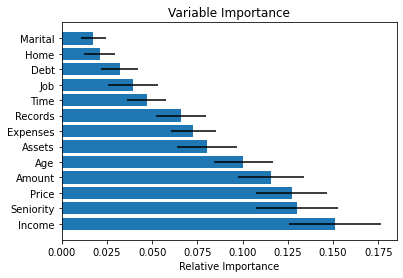

In [31]:
features = data.columns[:-1]
variables_importances(x_train_norm, y_train, features)

❗ **Importance des variables**
> les variables les plus importantes sont income, seniority, price. Cela est logique puisque une personne ayant un revenu élévé est facilement solvable.
> les variables les moins importantes sont marital, home, debt. Le mariage n'est pas forcement un indicateur important pour juger la solvabilité d'une personne. Une personne celibataire comme une personne mariée peuvent tous être solvable ou pas. Le statut marital  ne donne pas forcement une credibilité à la solvabilité d'une personne.  

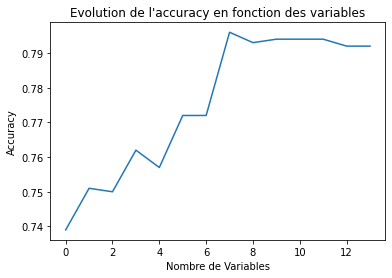

In [32]:
variables_selection(models['mlp'], x_train_norm, y_train, x_test_norm, y_test, sorted_idx)

❗**Nombre de variables à selectionner**
* le nombre de variables donnant le meilleur accuracy est __8__

##**6- Paramétrage des classifieurs**


In [33]:
model = MLPClassifier(hidden_layer_sizes=(70, 20), random_state=1)

In [34]:
x_train_select = x_train_norm[:,sorted_idx[:8]]

### Optimisation des hyperparamètres

🔑 **Gridsearch** 
>Le grid search est une méthode utilisée pour optimiser les hyperparamètres d'un modèle de machine learning en testant différentes combinaisons de valeurs d'hyperparamètres sur un jeu de données de validation. La performance du modèle est évaluée pour chaque combinaison de paramètres, et la combinaison qui donne les meilleures résultats est sélectionnée comme étant la meilleure. 

In [35]:
# grille de parametres
params = {
    'hidden_layer_sizes': [(40, 20), (30, 10), (40, 15), (10, 20)],
    'activation': ['tanh', 'sigmoid', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1,]

}

In [36]:
# Gridsearch
grid_search = GridSearchCV(model, params)
grid_search.fit(x_train_select, y_train )

GridSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(70, 20),
                                     random_state=1),
             param_grid={'activation': ['tanh', 'sigmoid', 'relu'],
                         'hidden_layer_sizes': [(40, 20), (30, 10), (40, 15),
                                                (10, 20)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [0.001, 0.01, 0.1],
                         'solver': ['sgd', 'adam']})

In [37]:
# Meilleur score 
grid_search.best_score_

0.7832502638370793

In [38]:
# Meilleurs paramètres obtenus
grid_search.best_params_

{'activation': 'tanh',
 'hidden_layer_sizes': (10, 20),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'solver': 'adam'}

🔑 **Meilleurs parametres**
> * activation: 'tanh',
*hidden_layer_sizes: (10, 20),
*learning_rate: 'constant',
*learning_rate_init: 0.001,
*solver: 'adam'

## **7- Création d'un pipeline**


>**Un pipeline** en machine learning est un enchaînement de plusieurs étapes de traitement de données et d'apprentissage automatique. Il permet de regrouper différentes opérations de prétraitement, de transformation et d'estimation en un seul objet, ce qui peut être pratique pour automatiser des tâches de manière structurée et reproductible.

> Dans partie, on encapsule dans un objet, tous les operations éffectués precedemment.   

In [39]:
class FeatureSelection:
  """
  Class pour representer la selection des features.
  """
  def __init__(self,sorted_idx, nbr_feature):
    self.sorted_idx = sorted_idx
    self.nbr_feature = nbr_feature
     
  def fit(self, X, Y):
    return X[:, sorted_idx[:self.nbr_feature]], Y
  
  def transform(self, X):
    return X[:, sorted_idx[:self.nbr_feature]]    

In [40]:
model = grid_search.best_estimator_
fs = FeatureSelection(sorted_idx, 8)

### Création du Pipeline

In [41]:
# Création du pipeline
pipe = Pipeline([('normalization', min_max), ('feature_selection', fs), ('model', model)])

In [42]:
pipe.predict(x_test[0].reshape(1, *x_test[0].shape))

array([1])

In [43]:
pipe.score(x_test, y_test )

0.7902193784277879

### Exportation du Pipeline

In [44]:
# Exportation de la pipeline
import pickle
with open('model_credit.pkl', 'wb') as f:
  pickle.dump(pipe, f, pickle.HIGHEST_PROTOCOL)

### Importation du pipeline

In [45]:
# Importation de la pipeline sauvegardée
with open('model_credit.pkl', 'rb') as f:
  pipe_imported = pickle.load(f)


In [46]:
pipe_imported.score(x_test, y_test)

0.7902193784277879

## **8. Comparaison de plusieurs algorithmes** 


> Dans cette partie on compare plusieurs algorithmes selon un certain nombre de critères.

In [47]:
# Chargement de données
data = pd.read_csv('credit_scoring.csv', sep=';')

In [48]:
# Extraction des features et targets
X = data.iloc[:,:].values
x_data = X[:, :-1]
y_data = X[:, -1]

In [49]:
# Normalisation des données 
x_data_norm = MinMaxScaler().fit_transform(x_data)

In [50]:
# Dictionnaire des algorithmes à comparer
clfs = {
    'RF' : RandomForestClassifier(n_estimators=50, random_state=1),
    'KNN' : KNeighborsClassifier(n_neighbors=10),
    'DT' : DecisionTreeClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'B' : BaggingClassifier(n_estimators=50),
    'ADA' : AdaBoostClassifier(n_estimators=50),
    'NB' : GaussianNB()
}

In [51]:
import time
def run_classifiers(clfs, X, y):
    """
        run models 
    """
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = {'Precision_mean': [], 'Precision_std': [], 'Accuracy_mean': [], 'Accuracy_std': [],
              'AUC_mean': [], 'AUC_std': [], 'Exec_time': []}
    for key, val in clfs.items():
        
        delta1 = time.time() 
        scoring = cross_validate(val,X, y, cv=kf, scoring=['precision', 'accuracy', 'roc_auc'])
        delta2 = time.time()
        
        scores['Precision_mean'].append(np.mean(scoring['test_precision']))
        scores['Precision_std'].append(np.std(scoring['test_precision']))
        
        scores['Accuracy_mean'].append(np.mean(scoring['test_accuracy']))
        scores['Accuracy_std'].append(np.std(scoring['test_accuracy']))
        
        scores['AUC_mean'].append(np.mean(scoring['test_roc_auc']))
        scores['AUC_std'].append(np.std(scoring['test_roc_auc']))
        
        scores['Exec_time'].append(delta2 - delta1)
         
        
    df = pd.DataFrame(scores, index=list(clfs.keys()))
    return df

### **Sans Normalisation**

In [52]:
run_classifiers(clfs, x_data, y_data)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.818831,0.016441,0.782169,0.014083,0.822798,0.014985,3.018179
KNN,0.778454,0.019620,0.731652,0.016245,0.680238,0.036953,0.338254
DT,0.804840,0.020815,0.721371,0.023225,0.649533,0.031668,0.257365
MLP,0.804251,0.061927,0.699196,0.079948,0.735424,0.030031,8.332518
B,0.825237,0.016327,0.780341,0.012145,0.815724,0.016561,7.804719
ADA,0.822515,0.017518,0.788110,0.015590,0.829275,0.021240,2.374357
NB,0.828111,0.017918,0.772109,0.021881,0.790916,0.025893,0.060582


🔑 **Comparaison**
> * Le meilleur modèle est Adaboost, il obtient les meilleurs resultats dans presque tous les critères (precision, accuracy, auc).
> * En termes de temps d'execution, le  Naive Bayes est le meilleur, 10 fois plus rapide que Random fores et le KNN et 40 plus rapide que ADA. Il a aussi la meilleure precision moyenne.
> * Le MLP a la plus petite accuracy.      

### **Normalization**

In [53]:
run_classifiers(clfs, x_data_norm, y_data)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.818635,0.016131,0.782853,0.014320,0.822830,0.015287,2.951030
KNN,0.817957,0.021284,0.758164,0.024188,0.767221,0.023254,0.534729
DT,0.807137,0.021889,0.724345,0.023191,0.653577,0.032462,0.255959
MLP,0.826355,0.014635,0.789941,0.011833,0.835319,0.018537,23.793192
B,0.824896,0.016337,0.774394,0.012961,0.817887,0.018624,7.705962
ADA,0.822515,0.017518,0.788110,0.015590,0.829275,0.021240,2.364590
NB,0.841357,0.015736,0.767772,0.018929,0.795059,0.025065,0.069930


🔑 **Comparaison**
> * **MLP** a la meilleure accuracy et AUC moyenne et une precision relativement importante mais avec temps d'execution très important (400 fois que le Naive bayes et 8 fois que le Random forest)
* **Naive bayes** a la meilleure precision moyenne et un temps d'execution très faible de l'ordre de centième par rapport à tous les modèles.
* **Meilleure Accuracy** : MLP, ADABoost, Random Forest
* **Meilleure precision** : Naive Bayes, MLP, Bagging
* **Meilleure temps d'éxecution**: Naive bayes, Decision tree, KNN
* **Meilleure AUC** : MLP, ADAboost, Random forest
* **Pire temps d'execution** : MLP, Bagging, Random Forest, ADABoost       

# **II- Apprentissage supervisé : Données hétérogènes**  

🔑 **Données hétérogènes**
> Les données hétérogènes sont des données qui proviennent de sources différentes et qui peuvent avoir des formats différents, des structures de données différentes, ou des granularités différentes. Elles peuvent également être exprimées dans des unités différentes ou avoir des échelles de mesure différentes.

## **Chargement de données**


> Le fichier "credit.data" comporte 688 instances décrites par 15 variables caractéristiques (6 numériques, 9
catégorielles) et la variable à prédire "classe" (la dernière colonne du fichier) de nature nominale possédant un
nombre fini de valeurs (ici deux valeurs "+" et "–"). Il ne s’agit pas d’une tâche de régression, mais de
classification. Les exemples de ce jeu de données représentent des personnes (positifs et négatifs) pour lesquels
un crédit a été accordé ou non

In [54]:
# Chargement de données
data = pd.read_csv('credit.data', sep=None, names=['A' + str(i) for i in range(0, 16) ])
data.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+


In [55]:
# Extraction des features et targets
X = data.iloc[:,:].values[:, :-1]
Y = data.iloc[:,:].values[:,-1]

In [56]:
# Remplacement de + et - par respectivement 1, et 0 et conversion en int data type
Y = np.where(Y=='+', 1, Y)
Y = np.where(Y=='-', 0, Y)
Y = Y.astype(np.int)

In [57]:
# Extraction des colonnes numériques (col_num) et categorielles (col_cat)
col_num = [1, 2, 7, 10, 13, 14]
col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]

##**Données numériques**

> Dans cette section un pretraiment est effectué sur les données
* Remplacer les valeurs ? par des np.nan
* Suppression des lignes contenant des nan

     

In [58]:
# Extraction des colonnes numériques
X_num = X[:, col_num]

# Remplacement des ? par des np.nan
X_num[X_num=='?'] = np.nan

# Conversion en numpy array
X_num = X_num.astype(np.float)

# Extraction des lignes contenant des np.nan
nan_rows = np.isnan(X_num).any(axis=1)

# Suppression des lignes contenant des np.nan 
X_num = X_num[~nan_rows] 

In [59]:
# suppression des targets donc les lignes contiennent de valeurs null
Y_num = Y[~nan_rows]

In [60]:
n_zeros = np.histogram(Y_num)[0][0]
n_ones = np.histogram(Y_num)[0][-1]
print("Taille de l'échantillon : ", X_num.shape)
print(f"Nombre de targets =  0 : {n_zeros} ({round(n_zeros*100/len(Y_num), 2)}%)")
print(f"Nombre de targets = 1: {n_ones} ({round(n_ones*100/len(Y_num), 2)}%)")
print(f"Nombres de lignes avec des données manquantes: {nan_rows.sum()}")

Taille de l'échantillon :  (666, 6)
Nombre de targets =  0 : 367 (55.11%)
Nombre de targets = 1: 299 (44.89%)
Nombres de lignes avec des données manquantes: 22


In [61]:
clfs = {
    'RF' : RandomForestClassifier(n_estimators=50, random_state=1),
    'KNN' : KNeighborsClassifier(n_neighbors=10),
    'DT' : DecisionTreeClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'B' : BaggingClassifier(n_estimators=50),
    'ADA' : AdaBoostClassifier(n_estimators=50),
    'NB' : GaussianNB()
}

In [62]:
# Sans normalization
run_classifiers(clfs, X_num, Y_num )

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.808115,0.057625,0.788444,0.052703,0.840702,0.046008,1.096737
KNN,0.756428,0.075043,0.704116,0.054732,0.745043,0.042451,0.069503
DT,0.683116,0.050696,0.722230,0.039069,0.719847,0.041084,0.052963
MLP,0.701472,0.070004,0.693623,0.055483,0.723614,0.064319,1.489080
B,0.800560,0.042422,0.786884,0.048632,0.840353,0.046490,1.488360
ADA,0.761079,0.060375,0.770398,0.062758,0.840771,0.052779,1.037778
NB,0.832235,0.051526,0.716101,0.049632,0.793077,0.057967,0.035709


🔑**Sans Normalization**
- Meilleur accuracy : Random Forest
- Meilleure precision : Naive bayes
- Meilleure AUC : Adaboost

In [63]:
# Avec Normalization
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)
run_classifiers(clfs, X_num_scaled, Y_num)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.808115,0.057625,0.788444,0.052703,0.840512,0.045591,1.058688
KNN,0.822741,0.081804,0.728268,0.070027,0.799063,0.072877,0.066418
DT,0.694772,0.045876,0.726707,0.036720,0.722869,0.038435,0.047104
MLP,0.821846,0.074624,0.767277,0.049203,0.825604,0.056419,3.640445
B,0.799221,0.051824,0.785369,0.046607,0.832990,0.047760,1.474803
ADA,0.761079,0.060375,0.770398,0.062758,0.840771,0.052779,0.997747
NB,0.832235,0.051526,0.716101,0.049632,0.793124,0.057912,0.033691


🔑 Avec Normalization
- Meilleur accuracy : Random Forest
- Meilleure precision : Naive bayes
- Meilleure AUC : Adaboost

## **Traitement des données manquantes**

In [64]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer as Imputer

In [65]:
# Extraction des collones categorielles 
X_cat = X[:, col_cat]

In [66]:
for col_id in range(len(col_cat)):
  unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
  X_cat[:, col_id] = val_idx 

In [67]:
# Remplacement de données manquantes par la valeur la plus frequente de la colonne
imp_cat = Imputer(missing_values=0, strategy='most_frequent')
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)]) 

In [68]:
# Extraction des colonnes numériques et remplacement des valeurs manquantes 
# par la moyenne de la colonne  
X_num = X[:, col_num]
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float) 
imp_num = Imputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)

## **Traitement des variables Catégorielles et concaténation**

In [69]:
# Conversion des valeurs categorielles en valeurs numeriques avec OneHotEncoding
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()

# Normalization des valeurs numeriques et concatenation   
X_num_scaled = StandardScaler().fit_transform(X_num)
X_extended = np.concatenate([X_num_scaled, X_cat_bin], axis=1) 

In [70]:
run_classifiers(clfs, X_extended, Y)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.860505,0.042753,0.877920,0.029092,0.929815,0.029295,1.015974
KNN,0.881801,0.042787,0.847421,0.047651,0.910535,0.031243,0.124412
DT,0.792133,0.080501,0.816795,0.047153,0.816367,0.046366,0.130642
MLP,0.830443,0.056683,0.854625,0.042094,0.920446,0.037947,5.135624
B,0.843833,0.044895,0.864791,0.034535,0.929051,0.024723,1.804806
ADA,0.814491,0.069181,0.844437,0.036898,0.915874,0.031656,1.171716
NB,0.868394,0.094080,0.720972,0.048370,0.877746,0.044064,0.037470


> * Meilleure accuracy : Random forest
> * Meilleure precision : KNN, Naive bayes, Bagging, Random Forst 
> * Meilleure AUC : Random Forest
> * Meilleur temps d'execution: Naive bayes, Decision tree, KNN, ADAboost, Random Forest

# **III- Apprentissage sur des données textuelles**

>**objectif** : L’objectif dans cette partie est de faire une étude comparative entre plusieurs algorithmes d’apprentissage
supervisé sur un jeu de données textuelles de SMS ("SMSSpamCollection.data") pour prédire si un message
est un spam ou pas.

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [72]:
# Dictionnaire des algorithmes à comparer
clfs = {
    'RF' : RandomForestClassifier(n_estimators=50, random_state=1),
    'KNN' : KNeighborsClassifier(n_neighbors=10),
    'DT' : DecisionTreeClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1),
    'B' : BaggingClassifier(n_estimators=50),
    'ADA' : AdaBoostClassifier(n_estimators=50)
}

## **Chargement des données**

In [73]:
# Chargement de données
data = pd.read_csv("./SMSSpamCollection.data", sep="\t", names=['category', 'mail'])

In [74]:
data.head()

,category,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [75]:
# Extraction des targets et mails
X = data.values[:, 1]
Y = data.values[:, 0]

In [76]:
# remplacement de spam et ham par 1 et 0
Y = np.where(Y=='spam', 1, Y)
Y = np.where(Y=='ham', 0, Y)
Y = Y.astype(np.int)

In [77]:
n_zeros = np.histogram(Y)[0][0]
n_ones  = np.histogram(Y)[0][-1]

In [78]:
print("Taille de l'échantillon : ", X.shape)
print(f"Nombre de spams  : {n_zeros}")
print(f"Nombre de hams : {n_ones}")

Taille de l'échantillon :  (5572,)
Nombre de spams  : 4825
Nombre de hams : 747


## **Count Vectorizer**


🔑 **CounterVectorizer**
> **CountVectorizer** : pour splitter chaque texte en différents mots clés (termes), supprimer les mots clés vides (stopwords) et calculer la matrice de co-occurences. (extrait du TP)

In [79]:
count_vectorizer = CountVectorizer()
X_vec = count_vectorizer.fit_transform(X)
X_vec.shape

(5572, 8713)

In [80]:
run_classifiers(clfs, X_vec, Y)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,1.000000,0.000000,0.977208,0.005956,0.993086,0.004684,19.224099
KNN,1.000000,0.000000,0.894835,0.015463,0.853034,0.034272,1.939215
DT,0.907579,0.031563,0.972180,0.005867,0.932193,0.018368,1.877683
MLP,0.995462,0.006997,0.986000,0.002762,0.980061,0.011185,75.282800
B,0.930344,0.017405,0.973437,0.004879,0.980353,0.006093,65.499011
ADA,0.947573,0.023426,0.971465,0.004427,0.979419,0.010077,21.489893


## **TF-IDF**

🔑**TF-IDF**
>**Tf–idf term weighting** : une mesure statistique utilisée pour la normalisation et la pondération de l’importance d’un terme contenu dans un document, relativement à toute la collection des documents (ici les SMS).(extrait du TP)

❗ **TfidfVectorizer**
- TfidVectorizer : Combine CountVectorizer et TfidfTransformer

In [81]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X_tfidf_vect = tfidf_vectorizer.fit_transform(X) 

In [82]:
run_classifiers(clfs, X_tfidf_vect, Y)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.980588,0.013293,0.981155,0.004700,0.987589,0.004752,5.566117
KNN,1.000000,0.000000,0.901654,0.011352,0.864766,0.032027,1.276494
DT,0.874150,0.026549,0.966259,0.006468,0.931686,0.017877,2.210307
MLP,0.959342,0.024069,0.983846,0.004177,0.989185,0.003450,33.695565
B,0.911061,0.029424,0.971822,0.007366,0.982764,0.005485,66.100194
ADA,0.948179,0.023032,0.970207,0.007414,0.963963,0.012956,3.320439


## **TruncatedSVD**


**🔑TruncatedSVD**
> TruncatedSVD : une méthode de réduction de dimensions pour les matrices très creuses (sparses en anglais) qui permettra d’améliorer la représentation vectorielle des textes des SMS par une indexation sémantique latente. Cette dernière permet d'établir des relations entre un ensemble de documents et les termes qu'ils contiennent, en construisant des "concepts" liés aux documents et
aux termes. Elle permettra entre autre de résoudre les problèmes de synonymie (plusieurs mots avec un seul sens) et de polysémie (un seul mot avec plusieurs sens) (extrait du TP)

In [83]:
svd = TruncatedSVD(n_components=15)
X_svd = svd.fit_transform(X_tfidf_vect)

In [84]:
run_classifiers(clfs, X_svd, Y)

,Precision_mean,Precision_std,Accuracy_mean,Accuracy_std,AUC_mean,AUC_std,Exec_time
RF,0.945020,0.022538,0.973616,0.006330,0.982107,0.006564,5.392620
KNN,0.897479,0.026102,0.965361,0.005745,0.970183,0.008922,1.004257
DT,0.833614,0.047667,0.955668,0.011046,0.905842,0.024947,0.832764
MLP,0.888375,0.029776,0.965542,0.009112,0.979353,0.007429,29.794582
B,0.924547,0.033721,0.972359,0.008203,0.978057,0.011584,24.340201
ADA,0.865229,0.041783,0.957823,0.008435,0.968145,0.010419,6.599569


## **Pipeline**

In [85]:
pipeline = Pipeline([("CountTFVectorizer", TfidfVectorizer(max_features=100, stop_words="english")),("TruncatedSVD", TruncatedSVD(n_components=15)), 
                     ('RandomForest', RandomForestClassifier(n_estimators=50))])

## **Yelp**

> **Objectif**: Application du pipeline sur le jeu de données Yelp contenant un ensemble d'avis notés sur des lieux (restaurants, hôtels, etc.) donnés par des utilisateurs sur le site Yelp.com 

### **Chargement de données**

In [86]:
data = pd.read_csv("./yelp-text-by-stars.csv", sep=";", encoding="ISO-8859-1") 

In [87]:
data.head()

,Stars,Text
0,1,Boarded my English Mastiff here over New Year'...
1,1,Another case of the Emperor's New Clothes. So...
2,1,Came on Valentine's Day night having pre-bough...
3,1,2Nd time eating here today.1st time was great ...
4,1,Allegiant is a disaster. Their fares are chea...


In [88]:
X = data.values[:, 1]
Y = data.values[:, 0]
Y = Y.astype(np.int)

In [89]:
print(f"Taille de l'échantillon : {X.shape}")

Taille de l'échantillon : (47371,)


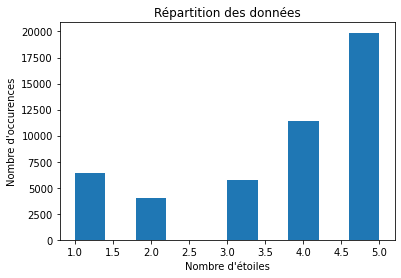

In [90]:
plt.title("Répartition des données")
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Nombre d'occurences")
plt.hist(Y)
plt.show()

### **Utilisation du pipeline**

In [91]:
pipeline.fit(X, Y)

Pipeline(steps=[('CountTFVectorizer',
                 TfidfVectorizer(max_features=100, stop_words='english')),
                ('TruncatedSVD', TruncatedSVD(n_components=15)),
                ('RandomForest', RandomForestClassifier(n_estimators=50))])

In [92]:
pipeline.score(X, Y)

0.9792911274830592



---



---


**❗ Score obtenu sur Yelp est de 0.97 (97.93%)**

---

